In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load training data
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# Define dataset sizes
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

# Download and load test data
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.65MB/s]


In [3]:
import torch.nn as nn

In [4]:
class MNIST_Network(nn.Module):
    def __init__(self):
        super(MNIST_Network, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 64)     # Second hidden layer
        self.fc3 = nn.Linear(64, 10)      # Output layer

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation here, as CrossEntropyLoss applies softmax
        return x

In [5]:
import torch.optim as optim

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MNIST_Network().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")

print("Training completed!")


Epoch [1/5], Train Loss: 0.4403, Val Loss: 0.2716, Val Accuracy: 91.89%
Epoch [2/5], Train Loss: 0.2146, Val Loss: 0.1969, Val Accuracy: 94.12%
Epoch [3/5], Train Loss: 0.1538, Val Loss: 0.1389, Val Accuracy: 95.63%
Epoch [4/5], Train Loss: 0.1222, Val Loss: 0.1275, Val Accuracy: 96.16%
Epoch [5/5], Train Loss: 0.1060, Val Loss: 0.1056, Val Accuracy: 96.75%
Training completed!


In [8]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


Final Test Accuracy: 96.86%


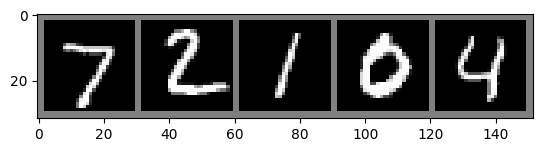

Predicted labels: [7 2 1 0 4]
Actual labels: [7 2 1 0 4]


In [9]:
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Display images
imshow(torchvision.utils.make_grid(images[:5]))

# Predict labels
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted labels:', predicted[:5].cpu().numpy())
print('Actual labels:', labels[:5].numpy())
